%config IPCompleter.greedy=True
%matplotlib inline

# Time Binning

Given a csv of all NetFlow entries, bin then into (5 minute bins)

In [43]:
# Premable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime
from dateutil.parser import parse
import collections
import math
import time
import os
import subprocess

pd_ewma = pd.Series.ewm

In [15]:
features = ['te', 'td', 'sa', 'da', 'sp', 'dp', 'pr', 'flg', 'fwd', 'stos', 'pkt', 'byt']

width = 5 * 60 # bin into 5 minutes
# df = pd.read_csv('data/test.csv')
df = pd.read_csv('data/2016-07-28/csv_week5_28_1000.csv')
df = df[features]

In [16]:
df.head()

,te,td,sa,da,sp,dp,pr,flg,fwd,stos,pkt,byt
0,2016-07-28 00:00:00,0.000,143.72.4.250,42.219.154.133,53,57353,UDP,.A....,0,0,1,104
1,2016-07-28 00:00:00,0.000,42.219.153.62,60.209.161.133,53,7910,UDP,.A....,0,0,1,199
2,2016-07-28 00:00:00,0.000,56.206.146.164,42.219.159.92,80,38579,TCP,.A..S.,0,72,1,44
3,2016-07-28 00:00:00,0.324,165.129.22.35,42.219.156.211,52914,80,TCP,.AP.SF,0,0,6,689
4,2016-07-28 00:00:00,0.604,74.217.140.141,42.219.158.156,9857,443,TCP,.AP.SF,0,72,5,729


In [17]:
datetimeStamp = "2016-07-27 13:43:30"
start = "2016-07-28"
end = "2016-07-29"
d = parse(datetimeStamp)
s = parse(start)
end = parse(end)
d > s

False

In [18]:
def createTimebin(row, timeWidth):
    d = parse(row['te'])
    return int(d.timestamp() // timeWidth)

In [19]:
# WARNING: LONG OPERATION
selectedFeatures = ['te', 'sa', 'da', 'sp', 'dp']
# df.head().apply (lambda row: createDatetime(row),axis=1)
df['timebin'] = df.apply (lambda row: createTimebin (row, width),axis=1)
df = df[['timebin'] + selectedFeatures]
df.head()

,timebin,te,sa,da,sp,dp
0,4898784,2016-07-28 00:00:00,143.72.4.250,42.219.154.133,53,57353
1,4898784,2016-07-28 00:00:00,42.219.153.62,60.209.161.133,53,7910
2,4898784,2016-07-28 00:00:00,56.206.146.164,42.219.159.92,80,38579
3,4898784,2016-07-28 00:00:00,165.129.22.35,42.219.156.211,52914,80
4,4898784,2016-07-28 00:00:00,74.217.140.141,42.219.158.156,9857,443


In [61]:
# aggreagate by count 
def aggByCount(df):
    grouped = df.groupby('timebin')
    nRecTimeSeries = grouped.agg('size').to_frame()
    nRecTimeSeries.columns = ['count']
    return nRecTimeSeries
    
def setIndexAsTime(df, width):
    _index = [datetime.datetime.fromtimestamp(i * width) for i in df.index]
    df.index = _index
    return df

nRecTimeSeries = aggByCount(df)
nRecTimeSeries = setIndexAsTime(nRecTimeSeries, width)
print(nRecTimeSeries.head())

                     count
2016-07-28 00:00:00    860
2016-07-28 00:05:00    833
2016-07-28 00:10:00   1016
2016-07-28 00:15:00    880
2016-07-28 00:20:00    937


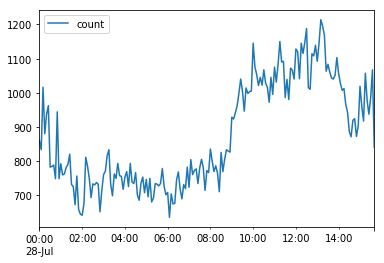

In [62]:
%matplotlib inline

nRecTimeSeries.plot()

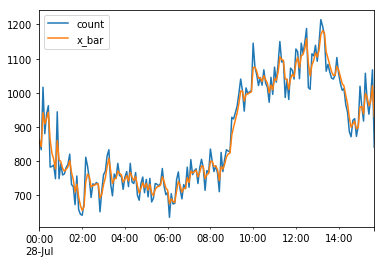

In [69]:
# nRecTimeSeries_ewma = ewma(nRecTimeSeries,span=3)
# nRecTimeSeries_ewma.mean().plot()
def ewma(df, sp = 3):
    temp = pd_ewma(df, span = sp).mean()
    df['x_bar'] = temp['count']
    return df

nRecTimeSeries_ewma = ewma(nRecTimeSeries, sp = 3)
nRecTimeSeries_ewma.plot()

In [70]:
nRecTimeSeries_ewma.head()

,count,x_bar
2016-07-28 00:00:00,860,860.000000
2016-07-28 00:05:00,833,842.000000
2016-07-28 00:10:00,1016,941.428571
2016-07-28 00:15:00,880,908.666667
2016-07-28 00:20:00,937,923.290323


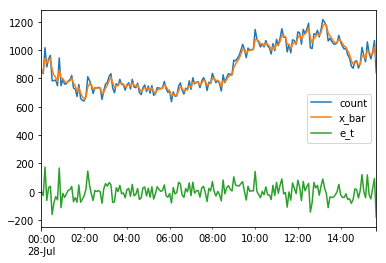

In [93]:
def forecastError(df):
    df['e_t'] = 0
#     df.loc[0, 'e_t'] = 0
    for i in range(1, len(df)):
        currIdx = df.index[i]
        prevIdx = df.index[i-1]
        df.loc[currIdx, 'e_t'] = df.loc[currIdx, 'count'] - df.loc[prevIdx, 'x_bar']
    return df
forecastError(nRecTimeSeries_ewma)
nRecTimeSeries_ewma.head()
nRecTimeSeries_ewma.plot()

In [130]:
# not sure what the defaults should be, depends on sampling rate
def upperThreshold(df, c_thres = 1, M_min = 1, c_cusum = 1):
    df['T_upper'] = 0
    df['S_t'] = 0
    df['T_cusum']=  0
    for i in range(2, len(df)):
        sigma = df['e_t'][:i].std()
        currIdx = df.index[i]
        prevIdx = df.index[i-1]
        T_val = df.loc[prevIdx, 'x_bar'] + max(c_thres * sigma, M_min)
        
        S_t_min_1 = df.loc[prevIdx, 'S_t']
        x_t = df.loc[currIdx, 'count']
        S_t = max(S_t_min_1 + x_t - T_val, 0)
        
        T_t = c_cusum * sigma
        
        df.loc[currIdx, 'T_upper'] = T_val
        df.loc[currIdx, 'S_t'] = S_t
        df.loc[currIdx, 'T_cusum'] = T_t
        
    return df
df2 = upperThreshold(nRecTimeSeries_ewma)
df2.head()

,count,x_bar,e_t,T_upper,S_t,T_cusum
2016-07-28 00:00:00,860,860.000000,0.000000,0.000000,0.000000,0.000000
2016-07-28 00:05:00,833,842.000000,-27.000000,0.000000,0.000000,0.000000
2016-07-28 00:10:00,1016,941.428571,174.000000,861.091883,154.908117,19.091883
2016-07-28 00:15:00,880,908.666667,-61.428571,1050.520276,0.000000,109.091705
2016-07-28 00:20:00,937,923.290323,28.333333,1013.464650,0.000000,104.797984


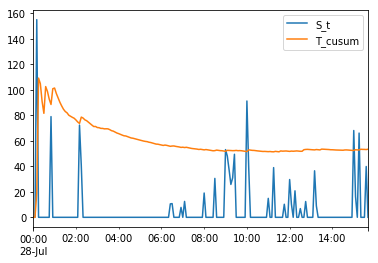

In [131]:
df2[['S_t', 'T_cusum']].plot()